In [1]:
import numpy as np
import jif
import matplotlib.pyplot as plt
%matplotlib inline

/Users/schneider42/Envs/wfirst_photoz/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
psfm = jif.PSFModel(achromatic=False, telescope='LSST')

In [3]:
# SED = psfm.get_SED()
# waves = np.logspace(np.log10(SED.red_limit), np.log10(SED.blue_limit), 200)

# plt.semilogx(waves, SED(waves))

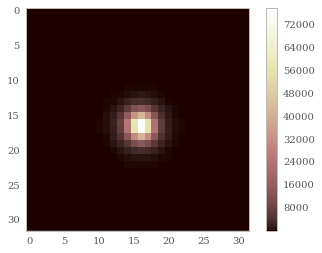

In [4]:
plt.imshow(psfm.get_psf_image(ngrid=32, filter_name='r').array, interpolation='none', cmap=plt.cm.pink)
plt.colorbar()

In [5]:
psfm.save_image('tmp.fits', ngrid=32)

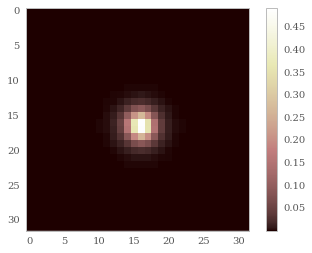

In [6]:
psfm.set_param_by_name('psf_mag', 30.)

plt.imshow(psfm.get_psf_image(ngrid=32, filter_name='r').array, interpolation='none', cmap=plt.cm.pink)
plt.colorbar()

## Construct the chromatic PSF in pieces to debug

In [7]:
import galsim
img = galsim.ImageF(64, 64, scale=0.2)

atmos = galsim.Kolmogorov(fwhm=0.6)

Here's at atmosphere PSF with no chromaticity

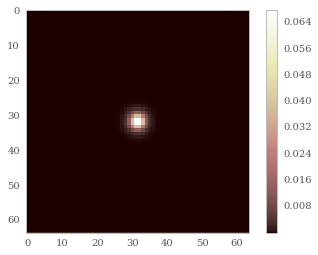

In [8]:
plt.imshow(atmos.drawImage(image=img).array, interpolation='none', cmap=plt.cm.pink)
plt.colorbar()

Now make a chromatic atmosphere PSF.

In [9]:
ra = galsim.HMS_Angle("14:03:13") # hours : minutes : seconds
dec = galsim.DMS_Angle("54:20:57") # degrees : minutes : seconds
m101 = galsim.CelestialCoord(ra, dec)
latitude = 19.8207 * galsim.degrees # latitude of Mauna Kea
HA = -1.0 * galsim.hours # Hour angle = one hour before transit

# Then we can compute the zenith angle and parallactic angle (which is is the position angle
# of the zenith measured from North through East) of this object:
za, pa = galsim.dcr.zenith_parallactic_angles(m101, HA=HA, latitude=latitude)
print "zenith angle: ", za
print "parallactic angle: ", pa

zenith angle:  0.634848963521 radians
parallactic angle:  2.71852242739 radians


In [10]:
atmosc = galsim.ChromaticAtmosphere(atmos, 500.,
                                    zenith_angle=za,
                                    parallactic_angle=pa)

filters = jif.telescopes.load_filter_files()

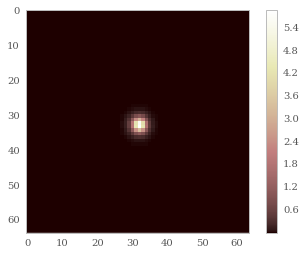

In [11]:
plt.imshow(atmosc.drawImage(filters['r'], image=img).array, interpolation='none', cmap=plt.cm.pink)
plt.colorbar()

## Convolve chromatic PSF with chromatic galaxy

In [28]:
import os
import galsim
redshift = 0.1
mono_gal = galsim.DeVaucouleurs(half_light_radius=0.5)
# read in SEDs
SED_names = jif.parameters.k_SED_names
datapath = '../input'
SEDs = {}
for SED_name in SED_names:
    SED_filename = os.path.join(datapath, '{0}.sed'.format(SED_name))
    SED = galsim.SED(SED_filename, wave_type='Ang')

    SEDs[SED_name] = SED.withFluxDensity(target_flux_density=1.0, wavelength=500)
SED = SEDs[SED_names[0]].atRedshift(redshift)
gal = galsim.Chromatic(mono_gal, SED)    

In [31]:
final = galsim.Convolve([mono_gal, psfm.get_psf()])

In [32]:
filters = jif.telescopes.load_filter_files()
img = galsim.ImageF(64, 64, scale=0.2)
final.drawImage(filters['r'], image=img)

RuntimeError: Image Error: Attempt to create an Image with non-positive ncol (-2147483646) and nrow (-2147483646)